In [ ]:
'''   

input - min, max, average temp from day before + min, max, average humidity from day before

https://www.wunderground.com/history/daily/us/tx/austin/KAUS/date/2024-3-15

https://www.wunderground.com/history/daily/us/il/chicago/KMDW/date/2024-3-15

https://www.wunderground.com/history/daily/us/fl/miami/KMIA/date/2024-3-15


'''



In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os
import datetime
import time

chrome_options = Options()
chrome_options.add_argument('--headless')  # Run Chrome in headless mode (without a graphical user interface)
chrome_service = ChromeService(executable_path='/Users/samdvorin/Desktop/code/542/weather-prediction/chromedriver')  # Replace with the path to your chromedriver executable
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

# Function to format the date string
def format_date(year, month):
    return f"{year}-{month:02}"

# Define the range of months to loop through
start_year = 2021
end_year = 2024
months = [2, 3, 4]  # February, March, April

# Create the folder if it doesn't exist
folder_name = "mia_daily_average_febmarchapril"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Loop through each year and month
for year in range(start_year, end_year + 1):
    for month in months:
        try:
            start_time = time.time()  # Record the start time
            year_month = format_date(year, month)
            url = f'https://www.wunderground.com/history/monthly/us/fl/miami/KMIA/date/{year_month}'
            driver.get(url)

            # Add implicit wait with a timeout of 10 seconds
            driver.implicitly_wait(10)

            # Locate the table element using WebDriverWait for better reliability
            table_element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "/html/body/app-root/app-history/one-column-layout/wu-header/sidenav/mat-sidenav-container/mat-sidenav-content/div[2]/section/div[2]/div[1]/div[5]/div[1]/div/lib-city-history-observation/div/div[2]")))

            # Extract the text from the table
            table_text = table_element.text

            # Save table_text to a text file inside the folder
            filename = os.path.join(folder_name, f"mia_{year_month}.txt")
            with open(filename, "w") as file:
                file.write(table_text)
            
            end_time = time.time()  # Record the end time
            elapsed_time = end_time - start_time  # Calculate elapsed time
            print(f"Saved table for {year_month} to {filename}. Elapsed time: {elapsed_time:.2f} seconds")
        except Exception as e:
            print(f"Error occurred while processing {year_month}: {e}")
            continue
        
        # Check if elapsed time is greater than 3 minutes, move to the next month
        if elapsed_time > 180:
            print(f"Elapsed time exceeded 3 minutes for {year_month}. Moving to the next month.")
            break

driver.quit()


In [8]:
import pandas as pd
from io import StringIO

# Read the text file
with open('chi_daily_average_febmarchapril/chi_2020-02.txt', 'r') as file:
    data = file.read()

# Replace spaces with commas
data = data.replace(' ', ',')

with open('weather_data.csv', 'w') as file:
    file.write(data)

In [10]:
# read in csv
# if line two is feb, numday is 28, if march numday is 31, april 30
# delete up to line numday+3
# save next numday lines in format (temp_max, temp_avg, temp_min)
# delete next line
# save next numday lines in format (Dew_Point_max, Dew_Point_avg, Dew_Point_min)
# delete next line
# same for humidity
#delete next line
# same for windspeed
# dlete next line
# same for pressure
# each day  should have max, min, avg for each of the various feilds
# end dataframe should be 15 columns with numday rows



In [2]:
import pandas as pd
import os

# Function to convert text files to CSV with space as delimiter
def txt_to_csv(file_path):
    csv_file_path = file_path.replace('.txt', '.csv')
    with open(file_path, 'r') as txt_file:
        lines = txt_file.readlines()
        with open(csv_file_path, 'w') as csv_file:
            for line in lines:
                csv_file.write(','.join(line.split()) + '\n')

# Specify the folder path
folder_path = 'chi_daily_average_febmarchapril'

'''
folder_path1 = 'mia_daily_average_febmarchapril'
folder_path2 = 'nyc_daily_average_febmarchapril'
folder_path3 = 'aus_daily_average_febmarchapril'
'''

# Initialize an empty list to store all DataFrames
all_dataframes = []

# Determine the number of days in March 2024
current_year = 2024
current_month = 3
num_days_march_2024 = 18

# Iterate over each file in the folder
for file_name in os.listdir(folder_path):
    # Convert text file to CSV
    if file_name.endswith('.txt'):
        txt_file_path = os.path.join(folder_path, file_name)
        txt_to_csv(txt_file_path)
        file_name = file_name.replace('.txt', '.csv')
    
    # Extract month information from the file name
    file_name_parts = file_name.split('_')[1].split('-')
    year, month = file_name_parts[0], file_name_parts[1].replace('.csv', '')
    month_abbr = pd.to_datetime(month, format='%m').strftime('%b')
    
    # Determine the number of days in the current month
    if month == '02':
        num_days = 28 if not (int(year) % 4 == 0 and (int(year) % 100 != 0 or int(year) % 400 == 0)) else 29  # Leap year check
    elif month in ['04', '06', '09', '11']:
        num_days = 30
    elif year == str(current_year) and month == str(current_month):
        num_days = num_days_march_2024
    else:
        num_days = 31

    # Read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(folder_path, file_name))
    
    df = df.iloc[:, :3]
    df = df.iloc[num_days + 3:, :]
    
    # Skip lines containing "Min", "Max", "Avg"
    df = df[~df.iloc[:, 0].str.contains('Min|Max|Avg|Total')]
    
    # Temperature DataFrame
    temp_df = df.iloc[0:num_days, 0:3].reset_index(drop=True)
    temp_df.columns = ['Max_Temp', 'Avg_Temp', 'Min_Temp']

    # Dew Point DataFrame
    dew_df = df.iloc[num_days:2*num_days, 0:3].reset_index(drop=True)
    dew_df.columns = ['Max_Dew', 'Avg_Dew', 'Min_Dew']

    # Humidity DataFrame
    humidity_df = df.iloc[2*num_days:3*num_days, 0:3].reset_index(drop=True)
    humidity_df.columns = ['Max_Humidity', 'Avg_Humidity', 'Min_Humidity']

    # Wind Speed DataFrame
    wind_df = df.iloc[3*num_days:4*num_days, 0:3].reset_index(drop=True)
    wind_df.columns = ['Max_Wind', 'Avg_Wind', 'Min_Wind']

    # Pressure DataFrame
    pressure_df = df.iloc[4*num_days:5*num_days, 0:3].reset_index(drop=True)
    pressure_df.columns = ['Max_Pressure', 'Avg_Pressure', 'Min_Pressure']
    
    # Combine the data for each feature into one DataFrame
    file_combined_df = pd.concat([temp_df, dew_df, humidity_df, wind_df, pressure_df], axis=1)
    
    # Add a date column
    file_combined_df['Date'] = pd.date_range(start=f"{year}-{month_abbr}-01", periods=len(file_combined_df), freq='D')
    
    # Append the combined DataFrame to the list
    all_dataframes.append(file_combined_df)

# Concatenate all DataFrames in the list to create one big DataFrame
chi_big_dataframe = pd.concat(all_dataframes, ignore_index=True)

# Save the combined DataFrame to a CSV file
chi_big_dataframe.to_csv('combined_data.csv', index=False)




In [3]:


big_dataframe = chi_big_dataframe.drop_duplicates(subset='Date', keep='first')
import matplotlib.pyplot as plt

# Convert temperature columns to numeric, coercing errors to NaN
temperature_columns = ['Max_Temp', 'Avg_Temp', 'Min_Temp']
big_dataframe[temperature_columns] = big_dataframe[temperature_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in temperature columns
sorted_dataframe = big_dataframe.dropna(subset=temperature_columns)
sorted_dataframe.head()


/var/folders/mf/txv8p7fx2yz68v4bx9pfbxf80000gn/T/ipykernel_21568/52593881.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_dataframe[temperature_columns] = big_dataframe[temperature_columns].apply(pd.to_numeric, errors='coerce')


,Max_Temp,Avg_Temp,Min_Temp,Max_Dew,Avg_Dew,Min_Dew,Max_Humidity,Avg_Humidity,Min_Humidity,Max_Wind,Avg_Wind,Min_Wind,Max_Pressure,Avg_Pressure,Min_Pressure,Date
0,57,45.7,32,38,33.1,29,100,66.2,38,13,4.8,0,29.6,29.5,29.4,2020-04-01
1,69,56.8,46,49,39.5,31,77,54.4,36,14,7.2,0,29.4,29.4,29.3,2020-04-02
2,56,43.1,38,50,39.0,34,97,86.0,68,15,9.2,0,29.5,29.4,29.3,2020-04-03
3,49,42.2,37,35,28.4,16,93,63.3,27,17,9.1,0,29.6,29.5,29.5,2020-04-04
4,65,52.0,37,57,42.1,33,97,71.6,41,14,6.6,0,29.5,29.4,29.2,2020-04-05


In [181]:
import pandas as pd

# Assuming df is your dataframe with the columns mentioned
# Sort the dataframe by the 'Date' column to ensure chronological order
df = sorted_dataframe.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Create a new dataframe for the formatted data
formatted_df = pd.DataFrame()

# Select the input features
input_features = ['Max_Temp', 'Avg_Temp', 'Min_Temp', 'Max_Humidity', 'Avg_Humidity', 'Min_Humidity', 'Max_Wind', 'Avg_Wind', 'Min_Wind']

# Select the output feature
output_feature = 'Max_Temp_Next_Day'

# Add input features to the formatted dataframe
formatted_df[input_features] = df[input_features]

# Shift the 'Max_Temp' column to get the target variable (max_temp of the next day)
formatted_df[output_feature] = df['Max_Temp'].shift(-1)

# Add the 'Date' column to the formatted dataframe
formatted_df['Date'] = df['Date']

# Drop the last row if it has NaN values (due to shifting)
formatted_df.dropna(inplace=True)
formatted_df.head()

# Now formatted_df is ready for ridge regression with input features and output feature


,Max_Temp,Avg_Temp,Min_Temp,Max_Humidity,Avg_Humidity,Min_Humidity,Max_Wind,Avg_Wind,Min_Wind,Max_Temp_Next_Day,Date
0,54,43.3,35,82,64.8,45,23,15.0,3,46.0,2020-02-01
1,46,38.8,31,89,76.5,63,17,8.9,0,38.0,2020-02-02
2,38,34.8,31,79,69.4,61,28,20.6,13,31.0,2020-02-03
3,31,28.8,27,89,73.8,50,17,13.1,8,31.0,2020-02-04
4,31,29.0,28,89,81.5,69,21,12.0,6,37.0,2020-02-05


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from itertools import combinations
# Sort the dataframe by the 'Date' column to ensure chronological order
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Create a new dataframe for the formatted data
formatted_df = pd.DataFrame()

# Select the input features
all_features = ['Max_Temp', 'Avg_Temp', 'Min_Temp', 'Max_Humidity', 'Avg_Humidity', 'Min_Humidity', 'Max_Wind', 'Avg_Wind', 'Min_Wind']

# Select the output feature
output_feature = 'Max_Temp_Next_Day'

# Initialize variables to store the best feature combination and the corresponding error
best_features = []
lowest_error = float('inf')

# Iterate through different combinations of input features
for r in range(1, len(all_features) + 1):
    for feature_combination in combinations(all_features, r):
        input_features = list(feature_combination)
        

        # Add input features to the formatted dataframe
        formatted_df[input_features] = df[input_features]

        # Shift the 'Max_Temp' column to get the target variable (max_temp of the next day)
        formatted_df[output_feature] = df['Max_Temp'].shift(-1)

        # Add the 'Date' column to the formatted dataframe
        formatted_df['Date'] = df['Date']

        # Drop the last row if it has NaN values (due to shifting)
        formatted_df.dropna(inplace=True)

        # Split the data into training and testing sets
        X = formatted_df[input_features]
        y = formatted_df[output_feature]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Perform Ridge Regression
        ridge = Ridge(alpha=1.0)  # You can adjust the alpha value for regularization
        ridge.fit(X_train, y_train)

        # Predict on the test set
        y_pred = ridge.predict(X_test)

        # Calculate mean squared error
        error = np.mean((y_pred - y_test) ** 2)

        # Update the best feature combination if the error is lower
        if error < lowest_error:
            lowest_error = error
            best_features = input_features

        # Clear the formatted dataframe for the next iteration
        formatted_df = pd.DataFrame()

print("Best feature combination:", best_features)
print("Lowest error:", lowest_error)


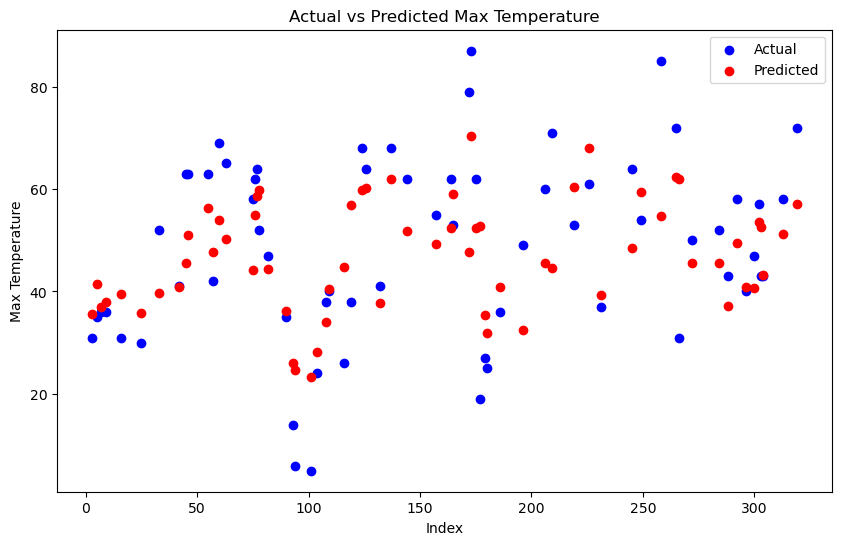

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from itertools import combinations

# Assuming df is your dataframe with the columns mentioned
# Sort the dataframe by the 'Date' column to ensure chronological order
df = sorted_dataframe.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Create a new dataframe for the formatted data
formatted_df = pd.DataFrame()

# Select the input features
input_features = ['Max_Temp', 'Avg_Temp', 'Min_Temp', 'Max_Humidity', 'Avg_Humidity', 'Min_Humidity', 'Max_Wind', 'Avg_Wind', 'Min_Wind']

# Select the output feature
output_feature = 'Max_Temp_Next_Day'

# Add input features to the formatted dataframe
formatted_df[input_features] = df[input_features]

# Shift the 'Max_Temp' column to get the target variable (max_temp of the next day)
formatted_df[output_feature] = df['Max_Temp'].shift(-1)

# Add the 'Date' column to the formatted dataframe
formatted_df['Date'] = df['Date']

# Drop the last row if it has NaN values (due to shifting)
formatted_df.dropna(inplace=True)
formatted_df.head()

# Assuming df is your dataframe with the columns mentioned
df = formatted_df.copy()
# Sort the dataframe by the 'Date' column to ensure chronological order
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Create a new dataframe for the formatted data
formatted_df = pd.DataFrame()

# Select the input features
input_features = ['Max_Temp', 'Min_Humidity']

# Select the output feature
output_feature = 'Max_Temp_Next_Day'

# Add input features to the formatted dataframe
formatted_df[input_features] = df[input_features]

# Shift the 'Max_Temp' column to get the target variable (max_temp of the next day)
formatted_df[output_feature] = df['Max_Temp'].shift(-1)

# Add the 'Date' column to the formatted dataframe
formatted_df['Date'] = df['Date']

# Drop the last row if it has NaN values (due to shifting)
formatted_df.dropna(inplace=True)
formatted_df.head()

# Now formatted_df is ready for ridge regression with input features and output feature

# Assuming formatted_df is your formatted DataFrame
# Split the data into training and testing sets
X = formatted_df[input_features]
y = formatted_df[output_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Ridge Regression
ridge = Ridge(alpha=1.0)  # You can adjust the alpha value for regularization
ridge.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test, color='blue', label='Actual')
plt.scatter(y_test.index, y_pred, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Max Temperature')
plt.title('Actual vs Predicted Max Temperature')
plt.legend()
plt.show()

In [20]:
import pandas as pd
from sklearn.linear_model import Ridge

# Assuming ridge is your trained Ridge regression model

def predict_max_temp_next_day(max_temp_today, min_humidity_today, ridge_model):
    # Create a DataFrame with the input features for the prediction
    input_data = pd.DataFrame({'Max_Temp': [max_temp_today], 'Min_Humidity': [min_humidity_today]})
    
    # Predict the max temperature of the next day
    max_temp_next_day = ridge_model.predict(input_data)
    
    return max_temp_next_day[0]

# nyc, aus, mia
max_temp_today = [46, 64, 77]
min_humidity_today = [26, 41, 43]

predicted_max_temp_next_day = []
for max_temp, min_humidity in zip(max_temp_today, min_humidity_today):
    predicted_max_temp_next_day.append(predict_max_temp_next_day(max_temp, min_humidity, ridge))

print("Predicted max temperature of the next day:", predicted_max_temp_next_day)


Predicted max temperature of the next day: [48.320731014732786, 58.17018352060639, 66.37279084773428]


In [ ]:
'''   
chicago march 19th prediciton 
Predicted max temperature of the next day: 40.62184684029434


nyc - 48
aus - 58
mia - 66
  '''

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Assuming df is your dataframe with the columns mentioned
# Sort the dataframe by the 'Date' column to ensure chronological order
df = sorted_dataframe.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Create a new dataframe for the formatted data
formatted_df = pd.DataFrame()

# Select the input features
input_features = ['Max_Temp', 'Min_Humidity']

# Select the output feature
output_feature = 'Max_Temp_Next_Day'

# Add input features to the formatted dataframe
formatted_df[input_features] = df[input_features]

# Shift the 'Max_Temp' column to get the target variable (max_temp of the next day)
formatted_df[output_feature] = df['Max_Temp'].shift(-1)

# Add a column for possible temperatures
possible_temps = []
for temp in formatted_df[output_feature]:
    # Generate a Gaussian distribution around the actual temperature
    temp_choices = np.random.normal(temp, 2, 10)  # Adjust the standard deviation as needed
    # Round the choices to the nearest multiple of 0.5
    temp_choices = np.round(temp_choices * 2) / 2
    possible_temps.append(temp_choices)

formatted_df['Possible_Temps'] = possible_temps
# Create binary features for each possible temperature
possible_temp_features = []
for temps in formatted_df['Possible_Temps']:
    temp_feature = [1 if temp in temps else 0 for temp in np.arange(0, 100, 0.5)]
    possible_temp_features.append(temp_feature)

temp_columns = ["Temp_" + str(temp) for temp in np.arange(0, 100, 0.5)]
formatted_df[temp_columns] = pd.DataFrame(possible_temp_features)

# Drop the 'Possible_Temps' column
formatted_df.drop(columns=['Possible_Temps'], inplace=True)

# Add the 'Date' column to the formatted dataframe
formatted_df['Date'] = df['Date']

# Drop the last row if it has NaN values (due to shifting)
formatted_df.dropna(inplace=True)

# Now formatted_df is ready for ridge regression with input features and output feature

# Assuming formatted_df is your formatted DataFrame
# Split the data into training and testing sets
X = formatted_df[input_features + ["Temp_" + str(temp) for temp in np.arange(0, 100, 0.5)]]
y = formatted_df[output_feature]
print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Ridge Regression
ridge = Ridge(alpha=1.0)  # You can adjust the alpha value for regularization
ridge.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test, color='blue', label='Actual')
plt.scatter(y_test.index, y_pred, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Max Temperature')
plt.title('Actual vs Predicted Max Temperature')
plt.legend()
plt.show()
